## This notebook prepares individual heatmaps of MHW category and temperature distribution overtime (1 specific year). 
### - json and png formats exported to Figures folder
### - it will be merged with an anomaly heatmap function Michael is preparing. 

## Import packages

In [15]:
import xarray as xr
import seaborn as sns
import numpy as np
import s3fs
import pandas as pd
import plotly.tools as tls
import plotly.io as pio
import cmocean
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go

____
# Accessing the Data Products

## Amazon Web Services Simple Storage Service (AWS S3)

Data can be accessed using AWS S3 or OPeNDAP links. I am using AWS S3 here as in practice it is often quicker than OPeNDAP. 

In [2]:
# load in methods for reading, writing, and managing files stored in S3. The connection is made anonamously. 
s3 = s3fs.S3FileSystem(anon=True) 

### AMDOT-EXT data products

In [3]:
# List all data folders available from UNSW
data_files = s3.ls("imos-data/UNSW/")
data_files

['imos-data/UNSW/NRS_climatology',
 'imos-data/UNSW/NRS_extremes',
 'imos-data/UNSW/NSW_Glider_climatology']

In [4]:
# List all data folders available from UNSW
data_files = s3.ls("imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2")
data_files

['imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/PH050',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/PH100',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/ROT055']

In [5]:
# List all data folders available from UNSW
data_files = s3.ls("imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090")
data_files

['imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090/MAI090_TEMP_EXTREMES_1944-2023_v2.nc',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090/MAI090_TEMP_MHWMCS_SUMMARY_1944-2023.csv']

In [6]:
# List all data folders available from UNSW
data_files = s3.ls("imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090")
data_files

['imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090/MAI090_TEMP_EXTREMES_1944-2023_v2.nc',
 'imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/MAI090/MAI090_TEMP_MHWMCS_SUMMARY_1944-2023.csv']

____

## Loading the files from S3 bucket

In [7]:
# use xarray to load in the datasets
# Note: this takes longer than expected, so I ran the code in the cells above instead to save the data to home
bucket_prefix = "imos-data/UNSW/NRS_extremes/Temperature_DataProducts_v2/"

MAI090 = xr.open_dataset(s3.open(bucket_prefix + "MAI090/MAI090_TEMP_EXTREMES_1944-2023_v2.nc"))
PH100 = xr.open_dataset(s3.open(bucket_prefix + "PH100/PH100_TEMP_EXTREMES_1953-2023_v2.nc"))

# if you instead want to load the data sets into memory, use the method .load() as in the cell above

In [8]:
MAI090['TEMP_EXTREME_INDEX']

<xarray.DataArray 'TEMP_EXTREME_INDEX' (TIME: 29176, DEPTH: 2)> Size: 233kB
[58352 values with dtype=float32]
Coordinates:
  * TIME     (TIME) datetime64[ns] 233kB 1944-01-02T12:00:00 ... 2023-11-18T1...
  * DEPTH    (DEPTH) float32 8B 2.0 21.0
Attributes:
    units:          1
    long_name:      extreme temperature event index
    standard_name:  status_flag
    valid_max:      12.0
    valid_min:      0.0
    flag_values:    [ 0.  1.  2. 11. 12.]
    flag_meanings:  no_event cold_spike marine_cold_spell heat_spike marine_h...

____

# Function to organise data into a day x month matrix for a selected year

In [9]:
def organize_temperature_into_dataframe(temp_dataarray):
    """
    Organizes temperature data into a DataFrame where rows are days of the month and columns are months.
    
    Parameters:
    temp_dataarray (xarray.DataArray): The temperature dataarray with time as one of the coordinates.
    empty_matrix (numpy.ndarray): The matrix to be filled with temperatures.

    Returns:
    pandas.DataFrame: The filled DataFrame with temperatures.
    """
    
    empty_matrix = np.ones((31,12)) * np.nan
    
    # Iterate over the temperature data
    for i in range(temp_dataarray.shape[0]):
        # Extract the date and corresponding day/month
        date = temp_dataarray.TIME[i].values
        day = np.datetime64(date, 'D').astype(object).day
        month = np.datetime64(date, 'M').astype(object).month
        
        # Fill the matrix at the corresponding day-1 (0-index) and month-1 (0-index) position
        empty_matrix[day - 1, month - 1] = temp_dataarray[i].values
    
    # Convert the matrix to a pandas DataFrame
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = list(range(1, 32))  # Days of the month (1 to 31)

    df = pd.DataFrame(empty_matrix.transpose(), index=months, columns=days)
    df.index.name = 'Day'  # Set the index name to 'Day'
    
    return df

____

# Example usage with a DataArray and an empty matrix



In [10]:
ds = MAI090['TEMP'].sel(
    TIME=slice('2022-01-01', '2022-12-31')).copy()
ds.values = MAI090['TEMP'].sel(
    TIME=slice('2022-01-01', '2022-12-31')).values - MAI090['TEMP_MEAN'].sel(
                        TIME=slice('2022-01-01', '2022-12-31')).values

Tanom = organize_temperature_into_dataframe(ds[:,1])

____

# Create heatmap for MHW Categories

In [11]:
ds = MAI090['MHW_EVENT_CAT'].sel(
    TIME=slice('2022-01-01', '2022-12-31')).copy()
ds.values = MAI090['MHW_EVENT_CAT'].sel(
    TIME=slice('2022-01-01', '2022-12-31')).values 

MHWCAT = organize_temperature_into_dataframe(ds[:,1])

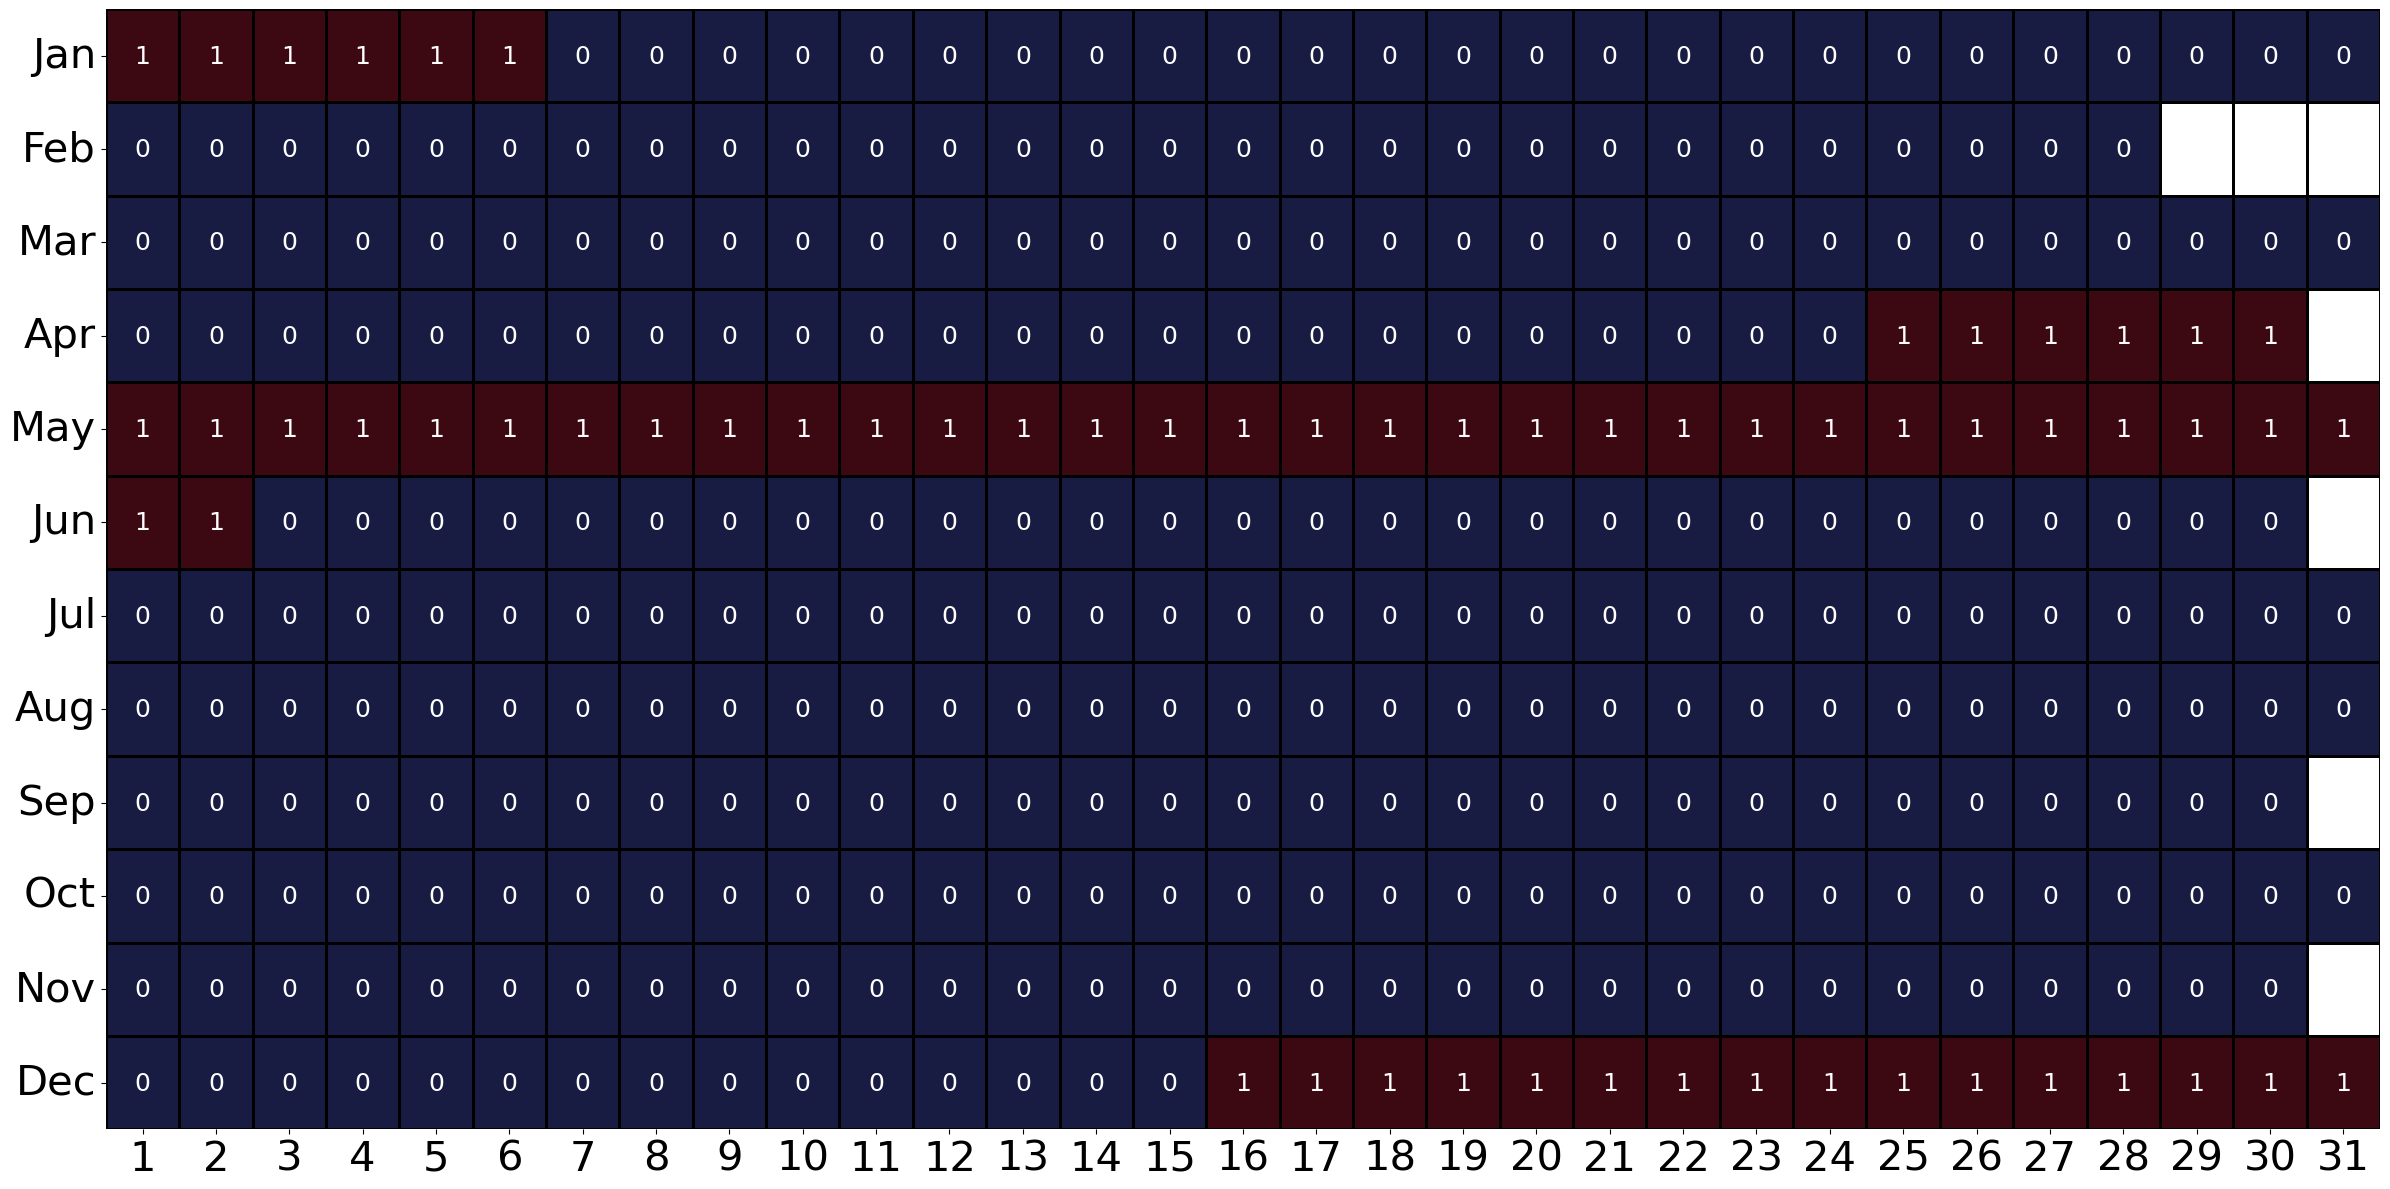

In [12]:
plt.figure(figsize=(24,12))
sns.heatmap(np.round(MHWCAT,2), annot=True, cmap=cmocean.cm.balance, 
            cbar_kws={'label': 'Temperature Anomaly'},  # Optional: Add colorbar label
            xticklabels=1, yticklabels=1, cbar=False, 
            annot_kws={"fontsize": 18}, linewidths=1, linecolor='black'  # Control the frequency of tick labels
            )

# Increase the fontsize of the tick labels, 
plt.xticks(fontsize=30)
plt.yticks(fontsize=30, rotation=360)
plt.ylabel('')

plt.tight_layout()

##save fig as png
save_results_to = '/g/data/v45/ns3783/ohw24_proj_MessageMeWhenItsHot_the_MHW_Vis-Report_app_au/Figures/'
plt.savefig(save_results_to + 'Heatmap_non_interactive_MHW_CAT_for_reference.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

_____

## Create a heatmap using Plotly - MHW Categories

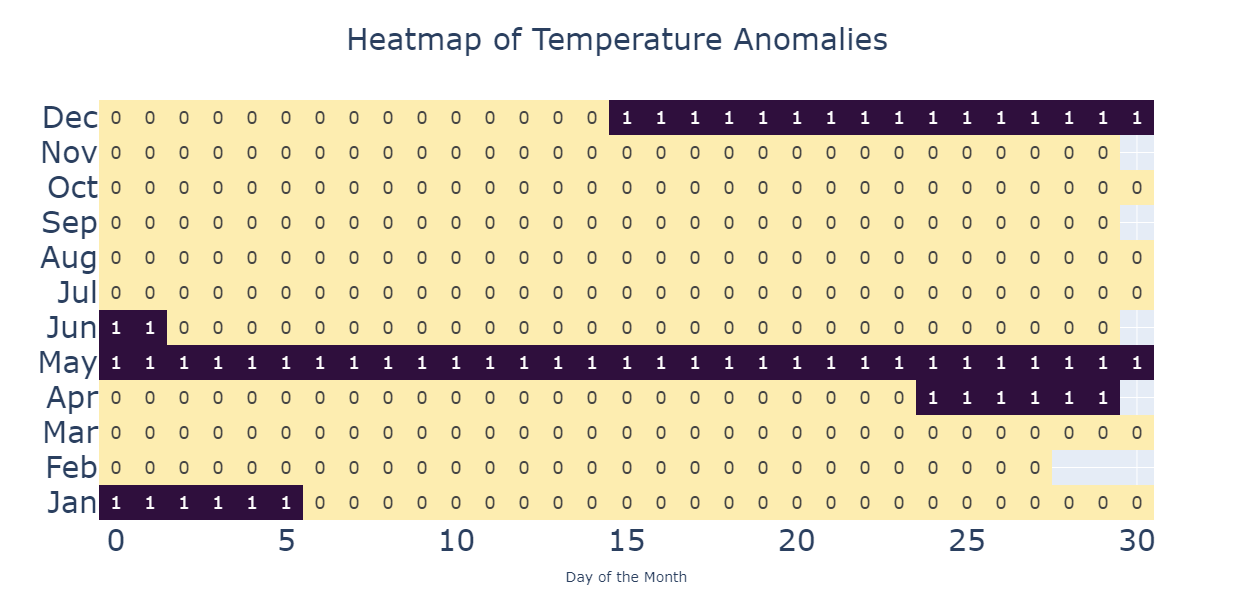

<Figure size 640x480 with 0 Axes>

In [39]:
# Convert the cmocean colormap to a Plotly-compatible colorscale
cmocean_colors = cmocean.cm.matter(np.linspace(0, 1, 256))
plotly_colorscale = [[i / (len(cmocean_colors) - 1), f'rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})'] for i, (r, g, b, a) in enumerate(cmocean_colors)]


heatmap_data = np.round(MHWCAT, 2)  # Your heatmap data

# Create a text array where NaNs are replaced with empty strings
text_data = np.where(np.isnan(heatmap_data), '', heatmap_data.astype(str))

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data,
    colorscale=plotly_colorscale,  # Use the converted colormap
    zmin=np.min(heatmap_data),
    zmax=np.max(heatmap_data),
    text=text_data,  # Display text only where there is data
    texttemplate='%{text:.0f}',
    textfont=dict(size=18),
    showscale=False
))

# Update layout for axis titles, tick labels, and figure dimensions
fig.update_layout(
    width=1200,  # Set the width of the figure
    height=600,  # Set the height of the figure
    xaxis=dict(
        tickfont=dict(size=30),
        title='Day of the Month',  # Adjust as needed
        tickangle=0
    ),
    yaxis=dict(
        tickfont=dict(size=30),
        title='',  # No y-axis title as per your seaborn plot
        tickvals=np.arange(12),  # Adjust if necessary based on your y-axis data
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    title='Heatmap of Temperature Anomalies',  # Adjust title as needed
    title_x=0.5,
    title_font=dict(size=30)
)

# Show figure
fig.show()

##save fig as png
save_results_to = '/g/data/v45/ns3783/ohw24_proj_MessageMeWhenItsHot_the_MHW_Vis-Report_app_au/Figures/'
plt.savefig(save_results_to + 'Heatmap_non_interactive_MHW_CAT_for_reference.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [36]:
# Define the directory where you want to save the HTML file
save_directory = '/g/data/v45/ns3783/ohw24_proj_MessageMeWhenItsHot_the_MHW_Vis-Report_app_au/Figures/'
# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Define the file path
file_path = os.path.join(save_directory, 'MHW_CAT_individual_HEATMAP_1_depth.json')

# Save the Plotly figure as an HTML file
pio.write_json(fig, file=file_path)


____

# Create normal and plotly heatmap for MHW events.

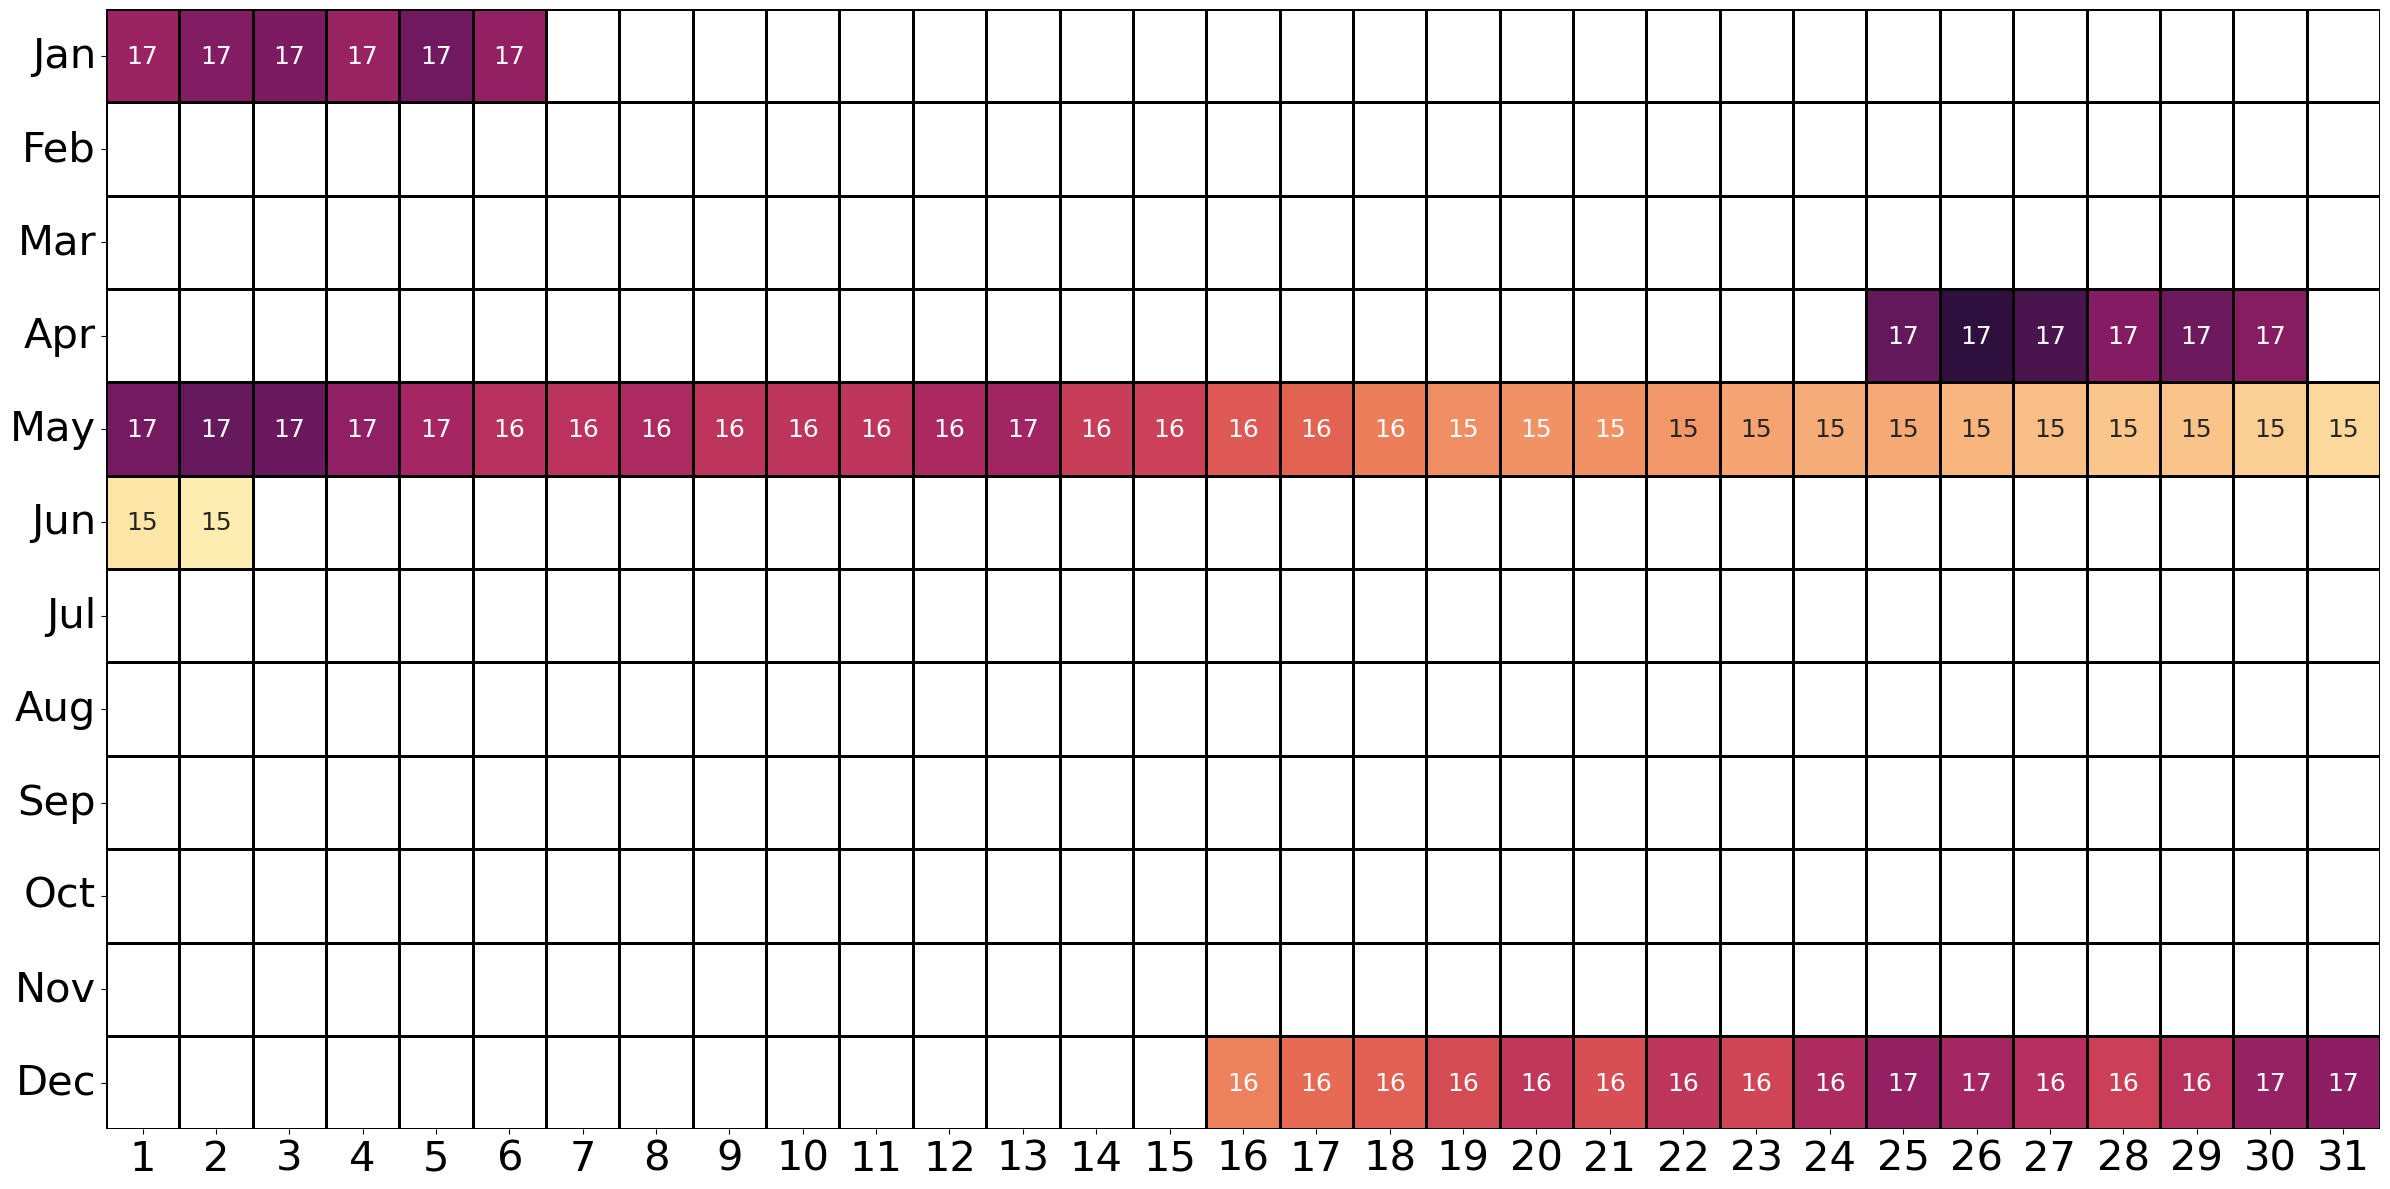

<Figure size 640x480 with 0 Axes>

In [38]:
depth_level = 21
index_mhw = 12
# Step 1: Filter the TEMP data based on TEMP_EXTREME_INDEX == 12
filtered_temp = MAI090['TEMP'].sel(
    TIME=slice('2022-01-01', '2022-12-31'), DEPTH=depth_level).where(
    MAI090['TEMP_EXTREME_INDEX'].sel(DEPTH=depth_level) == index_mhw)

# Step 2: Organize the filtered TEMP data into a DataFrame
temp_dataframe = organize_temperature_into_dataframe(filtered_temp)

# Step 3: Plot the heatmap
plt.figure(figsize=(24,12))
sns.heatmap(np.round(temp_dataframe, 2), annot=True, cmap=cmocean.cm.matter, 
            #cbar_kws={'label': 'Temperature ($^{\circ}C$)'},  # Optional: Add colorbar label
            xticklabels=1, yticklabels=1, cbar=False, 
            annot_kws={"fontsize": 18}, linewidths=1, linecolor='black')  # Control the frequency of tick labels

# Increase the fontsize of the tick labels
plt.xticks(fontsize=30)
plt.yticks(fontsize=30, rotation=360)
plt.ylabel('')

plt.tight_layout()
plt.show()

##save fig as png
save_results_to = '/g/data/v45/ns3783/ohw24_proj_MessageMeWhenItsHot_the_MHW_Vis-Report_app_au/Figures/'
plt.savefig(save_results_to + 'Heatmap_non_interactive_MHW_temp_for_reference.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

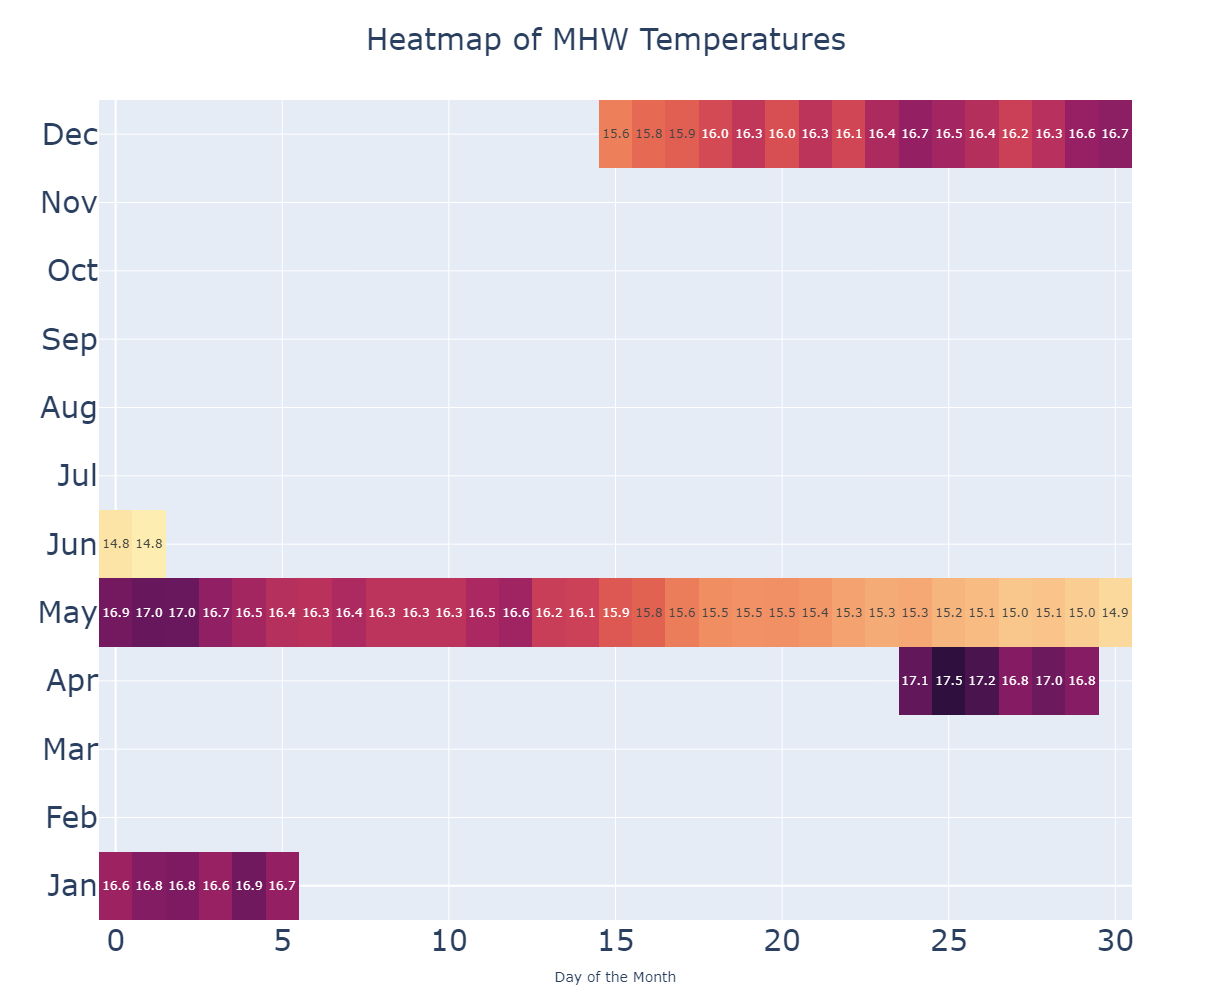

In [37]:
# Step 1: Convert the cmocean colormap to a Plotly-compatible colorscale
cmocean_colors = cmocean.cm.matter(np.linspace(0, 1, 256))
plotly_colorscale = [
    [i / (len(cmocean_colors) - 1), f'rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})']
    for i, (r, g, b, a) in enumerate(cmocean_colors)
]

# Step 2: Prepare the heatmap data
heatmap_data = np.round(temp_dataframe, 2)

# Create a text array with annotations only for non-null values
text_data = np.where(np.isnan(heatmap_data), '', np.round(heatmap_data, 1).astype(str))

# Step 3: Create the Plotly heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data,
    colorscale=plotly_colorscale,  # Use the converted colormap
    zmin=np.nanmin(heatmap_data),  # Adjust to avoid issues with NaNs
    zmax=np.nanmax(heatmap_data),
    text=text_data,  # Display text only where there is data
    texttemplate='%{text:.1f}',
    textfont=dict(size=12),
    showscale=False,  # Show the colorbar
    colorbar=dict(title='Temperature (°C)', tickvals=np.linspace(np.nanmin(heatmap_data), np.nanmax(heatmap_data), 5))
))

# Step 4: Update layout for axis titles, tick labels, and figure dimensions
fig.update_layout(
    width=1200,  # Set the width of the figure
    height=1000,  # Set the height of the figure
    xaxis=dict(
        tickfont=dict(size=30),
        title='Day of the Month',  # Adjust as needed
        tickangle=0
    ),
    yaxis=dict(
        tickfont=dict(size=30),
        title='',  # No y-axis title as per your Seaborn plot
        tickvals=np.arange(12),  # Assuming y-axis is months
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    title='Heatmap of MHW Temperatures',  # Adjust title as needed
    title_x=0.5,
    title_font=dict(size=30)
)

# Step 5: Show the figure
fig.show()

# Define the directory where you want to save the HTML file
save_directory = '/g/data/v45/ns3783/ohw24_proj_MessageMeWhenItsHot_the_MHW_Vis-Report_app_au/Figures/'
# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Define the file path
file_path = os.path.join(save_directory, 'MHW_temp_individual_HEATMAP_1_depth.json')

# Save the Plotly figure as an HTML file
pio.write_json(fig, file=file_path)


_____